<a href="https://colab.research.google.com/github/Feru34/Deep_Learning/blob/main/Talleres/Taller%202/Taller_2_Rueda_Felipe_Mijares_Alfredo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Logo ADL](https://github.com/fcastellanosp/MINE-4210_202420_ADL/blob/main/Laboratorios/logo_adl.png?raw=true)

# **Taller 2**

- **Integrante 1:** Felipe Rueda
- **Integrante 2:**

Bangladesh es una de los países con más tráfico en el mundo. Allí se encuentran algunas particularidades como los *rickshaw*, que son vehículos de 2 ruedas impulsados por una persona.

Los estudios indican que alrededos de 3.000 personas fallecen al año a causa de accidentes de tránsito.

Como consultor del sector de transporte, la organización ha procesado alrededor de 20.000 imágenes etiquetadas con información de objetos que pertenecen a las siguientes 13 clases:

* person
* rickshaw
* rickshaw van
* auto rickshaw
* truck
* pickup truck
* private car
* motorcycle
* bicycle
* bus
* micro bus
* covered van
* human hauler

Han sido contratados para buscar un proceso que permita acelerar el entendimiento de esta problemática, para el cuál le solicitan construir un modelo de detección de objetos que permita identificar los diferentes actores viales.

La información etiquetada se encuentra en  "[Bangladesh traffic](https://www.kaggle.com/datasets/hasibzunair/rsud20k-bangladesh-road-scene-understanding)".

# **Preguntas:**

1.   Construir una red neuronal de detección de objetos usando un modelo pre-entrenado. Recuerden ser descriptivos en el Preprocesamiento de Datos, Utilización de Modelos Pre-entrenados, Evaluación de Rendimiento y búsqueda de hiperparámetros.

2.  Proporcionar algunos ejemplos de detección de objetos con la red entrenada y lo comparen con la imagen con los datos anotados. Traten de usar imágenes con 1 objeto asi como imágenes con varios objetos.

3.  Investigar la métrica mAP y cómo la interpreta para la red entrenada.

4. Calcular el número de escenarios (imágenes) que involucran personas en el conjunto de prueba.

# **Notas Importantes:**
- Pueden usar la versión de Yolo del laboratorio u otra distinta.
- El archivo a presentar debe ser en formato .ipynb o HTML ya ejecutado. Celda que no esté ejecutada no se podrá evaluar.
- El nombre del archivo debe ser `Taller_2_{Apellido_Nombre}_{Apellido_Nombre}` de cada integrante respectivamente.

# 1. Construir una red neuronal de detección de objetos usando un modelo pre-entrenado

## Utilización de librerías

In [36]:
!rm -rf "/content/rsud20k-bangladesh-road-scene-understanding"

In [16]:

!pip install ultralytics==8.0.196

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.4.1+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 47.8/107.7 GB disk)


In [34]:
import pandas as pd
import numpy as np

import os
import os.path as osp
import random
import re
import shutil

#Visualización de datos
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from IPython.display import display, Image

from numpy import asarray

from PIL import Image

from ultralytics import YOLO

import os
import cv2

In [19]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## Preprocesamiento de datos

Para tener un mejor detalle sobre el comportamiento de la información, la organización ha dispuesto la información de la siguiente forma:

```python
Multi-Class Animal Detection.v1-yolov8.zip/
  train/
    images/
      a_image_1.png
      a_image_2.jpg
      .......    
    labels/
      a_image_1.txt
      a_image_2.txt
      .......
  valid/
    images/
      b_image_1.png
      b_image_2.jpg
      .......    
    labels/
      b_image_1.txt
      b_image_2.txt
      .......
  test/
    images/
      c_image_1.png
      c_image_2.jpg
      .......    
    labels/
      c_image_1.txt
      c_image_2.txt
      .......
```

### Parámetros generales y carga de la información

In [37]:
my_seed = 19 #Semilla para reproducibilidad
IMG_EXT = ['.jpg', '.jpeg', '.png', '.bmp'] #Extensiones válidas de imagen
TEXT_EXT = '.txt'
YOLO_VERSION = 'yolov8'

In [38]:
random.seed(my_seed)

### Configuración del entorno de kaggle.

Verificamos la conectividad con kaggle, usando un comando para ver una previsualización de datasets:

In [39]:
!ls -lha kaggle.json
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

-rw-r--r-- 1 root root 62 Oct  6 14:10 kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


Verificamos la conectividad con kaggle, usando un comando para ver una previsualización de datasets:

In [40]:
!kaggle datasets list

401 - Unauthorized - Unauthenticated


Una vez hemos asegurado la conectividad, procedemos a realizar el proceso de descarga de la información del negocio.

In [41]:
!kaggle datasets download -d hasibzunair/rsud20k-bangladesh-road-scene-understanding

Dataset URL: https://www.kaggle.com/datasets/hasibzunair/rsud20k-bangladesh-road-scene-understanding
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
rsud20k-bangladesh-road-scene-understanding.zip: Skipping, found more recently modified local copy (use --force to force download)


Para la información que vamos a descomprimir, es necesario crear un un directorio para que el contenido del archivo zip, se encuentre allí. Para este propósito, vamos a crear unas variables de manejo de archivos:

In [42]:
ROOT_DIR = '/content'
DATASET_NAME = 'rsud20k-bangladesh-road-scene-understanding'
SUB_DATASET_NAME = 'rsud20k'

Vamos ahora a generar una previsualización del comando de descompresión del archivo zip:

In [43]:
print(f"!unzip {DATASET_NAME}.zip -d {ROOT_DIR}/{DATASET_NAME}")

!unzip rsud20k-bangladesh-road-scene-understanding.zip -d /content/rsud20k-bangladesh-road-scene-understanding


Ahora si vamos a consolidar el bloque de comandos con todos los pasos para la descompresión del archivo zip:

In [44]:
%cd {ROOT_DIR}
!mkdir /{DATASET_NAME}
!unzip {DATASET_NAME}.zip -d {ROOT_DIR}/{DATASET_NAME}

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: /content/rsud20k-bangladesh-road-scene-understanding/rsud20k/labels/train/train6370.txt  
  inflating: /content/rsud20k-bangladesh-road-scene-understanding/rsud20k/labels/train/train6371.txt  
  inflating: /content/rsud20k-bangladesh-road-scene-understanding/rsud20k/labels/train/train6372.txt  
  inflating: /content/rsud20k-bangladesh-road-scene-understanding/rsud20k/labels/train/train6373.txt  
  inflating: /content/rsud20k-bangladesh-road-scene-understanding/rsud20k/labels/train/train6374.txt  
  inflating: /content/rsud20k-bangladesh-road-scene-understanding/rsud20k/labels/train/train6375.txt  
  inflating: /content/rsud20k-bangladesh-road-scene-understanding/rsud20k/labels/train/train6376.txt  
  inflating: /content/rsud20k-bangladesh-road-scene-understanding/rsud20k/labels/train/train6377.txt  
  inflating: /content/rsud20k-bangladesh-road-scene-understanding/rsud20k/labels/train/train6378.txt  
  inflating:

Generamos la ruta del directorio para cargar la información:

In [64]:
DATA_DIR_IMG = f"{ROOT_DIR}/{DATASET_NAME}/{SUB_DATASET_NAME}/images"
DATA_DIR_LBS = f"{ROOT_DIR}/{DATASET_NAME}/{SUB_DATASET_NAME}/labels"
DATA_DIR = f"{ROOT_DIR}/{DATASET_NAME}/{SUB_DATASET_NAME}"
print(DATA_DIR_IMG)
print(DATA_DIR_LBS)

/content/rsud20k-bangladesh-road-scene-understanding/rsud20k/images
/content/rsud20k-bangladesh-road-scene-understanding/rsud20k/labels


Verificamos las rutas de cada uno de los directorios:

In [46]:
subdirs = ['train', 'test', 'val']

In [47]:
train_img_folder = osp.join(DATA_DIR_IMG, subdirs[0])
train_lbl_folder = osp.join(DATA_DIR_LBS, subdirs[0])
val_img_folder = osp.join(DATA_DIR_IMG, subdirs[2])
val_lbl_folder = osp.join(DATA_DIR_LBS, subdirs[2])
test_img_folder = osp.join(DATA_DIR_IMG, subdirs[1])
test_lbl_folder = osp.join(DATA_DIR_LBS, subdirs[1])

Vamos a visualizar las rutas de las carpetas:

In [48]:
folder_list = [train_img_folder, train_lbl_folder,
                val_img_folder, val_lbl_folder,
                test_img_folder, test_lbl_folder
]

print("Imprimimos las rutas de las carpetas:")
for fa in folder_list:
  print(fa)

Imprimimos las rutas de las carpetas:
/content/rsud20k-bangladesh-road-scene-understanding/rsud20k/images/train
/content/rsud20k-bangladesh-road-scene-understanding/rsud20k/labels/train
/content/rsud20k-bangladesh-road-scene-understanding/rsud20k/images/val
/content/rsud20k-bangladesh-road-scene-understanding/rsud20k/labels/val
/content/rsud20k-bangladesh-road-scene-understanding/rsud20k/images/test
/content/rsud20k-bangladesh-road-scene-understanding/rsud20k/labels/test


In [49]:
folder_list = [train_img_folder, val_img_folder,
               test_img_folder
]

¿Necesitamos usar los tensores?, no en este caso, dado que la información ya está descargada, vamos a asegurar la taxonomía de la información que espera Yolo.

¿Debemos validar el tamaño de las imágenes?. Normalmente debe hacerse, para este proceso es posible hacer un recorrido sobre los archivos y contrastar con los metadatos. Como en este caso no ha sido suministrado por la organización, no realizaremos este proceso cruzado, imprimimos la información directamente desde las imágenes:

In [50]:
img_name_list = []
img_width_list = []
img_height_list = []
img_folder_list = []
img_format_list = []

for fa in folder_list:
  parent = os.path.dirname(fa)
  parent_name = os.path.basename(parent)
  for fname in os.listdir(fa):
    img_folder_list.append(parent_name)
    img_name_list.append(fname)
    img_path = osp.join(fa, fname)
    img_format_list = "ok" if osp.splitext(fname)[-1] in IMG_EXT else "not ok"

    with Image.open(img_path) as img:
      width, height = img.size
      img_width_list.append(width)
      img_height_list.append(height)

data_model = {"folder": img_folder_list, "image_name": img_name_list,
              "width": img_width_list, "height": img_height_list
              , "format": img_format_list}
report_df = pd.DataFrame(data=data_model)

Las imagenes tiene un tamaño horizontal de 1080x1920, algo que no soporta Yolo. Por lo que cambiamos el tamaño de los archivos para que tengan un tamaño cuarado 640x640

In [54]:
report_df.head()

,folder,image_name,width,height,format
0,images,train11207.jpg,1920,1080,ok
1,images,train2460.jpg,1920,1080,ok
2,images,train14720.jpg,1920,1080,ok
3,images,train18620.jpg,1920,1080,ok
4,images,train17749.jpg,1920,1080,ok


In [51]:
# Función para aplicar letterbox y adaptar el tamaño de las imágenes
def letterbox_image(image, expected_size=(640, 640)):
    ih, iw = image.shape[:2]  # Alto y ancho de la imagen original
    eh, ew = expected_size  # Alto y ancho esperados para YOLO

    # Escala para mantener la proporción
    scale = min(ew / iw, eh / ih)
    nw, nh = int(iw * scale), int(ih * scale)

    # Redimensionar la imagen con el nuevo tamaño escalado
    image_resized = cv2.resize(image, (nw, nh))

    # Crear una nueva imagen con el tamaño esperado y rellenar los bordes con color (negro)
    new_image = cv2.copyMakeBorder(image_resized,
                                   top=(eh - nh) // 2,
                                   bottom=(eh - nh) // 2,
                                   left=(ew - nw) // 2,
                                   right=(ew - nw) // 2,
                                   borderType=cv2.BORDER_CONSTANT,
                                   value=(0, 0, 0))

    return new_image

# Función para procesar las imágenes de un directorio
def process_images(input_dir, output_dir, expected_size=(640, 640)):
    for image_file in os.listdir(input_dir):
        if image_file.endswith((".png", ".jpg", ".jpeg")):  # Comprobar que sea una imagen
            image_path = os.path.join(input_dir, image_file)
            image = cv2.imread(image_path)

            if image is not None:
                # Aplicar letterbox
                processed_image = letterbox_image(image, expected_size=expected_size)

                # Guardar la nueva imagen procesada
                cv2.imwrite(os.path.join(output_dir, image_file), processed_image)

                print(f"Imagen {image_file} procesada, guardada correctamente.")

# Función para actualizar las etiquetas después de aplicar letterbox
def update_labels(label_file, orig_size, new_size=(640, 640), scale=None, padding=None):
    with open(label_file, 'r') as f:
        lines = f.readlines()

    updated_labels = []
    orig_w, orig_h = orig_size  # Tamaño original de la imagen
    new_w, new_h = new_size     # Tamaño nuevo de la imagen después de letterbox

    # Calculamos la escala y el padding si no se ha dado
    if scale is None:
        scale = min(new_w / orig_w, new_h / orig_h)

    if padding is None:
        padding_w = (new_w - orig_w * scale) / 2
        padding_h = (new_h - orig_h * scale) / 2

    for line in lines:
        data = line.strip().split()
        cls = int(data[0])
        x_center = float(data[1])
        y_center = float(data[2])
        width = float(data[3])
        height = float(data[4])

        # Convertimos las coordenadas normalizadas a las dimensiones originales
        x_center_orig = x_center * orig_w
        y_center_orig = y_center * orig_h
        width_orig = width * orig_w
        height_orig = height * orig_h

        # Ajustamos las coordenadas según el escalado y el padding
        x_center_new = (x_center_orig * scale + padding_w) / new_w
        y_center_new = (y_center_orig * scale + padding_h) / new_h
        width_new = (width_orig * scale) / new_w
        height_new = (height_orig * scale) / new_h

        # Aseguramos que las nuevas coordenadas estén dentro de los límites [0, 1]
        x_center_new = min(max(x_center_new, 0), 1)
        y_center_new = min(max(y_center_new, 0), 1)
        width_new = min(max(width_new, 0), 1)
        height_new = min(max(height_new, 0), 1)

        # Guardamos la nueva línea de etiquetas
        updated_labels.append(f"{cls} {x_center_new} {y_center_new} {width_new} {height_new}\n")

    # Guardamos las etiquetas actualizadas en el archivo original
    with open(label_file, 'w') as f:
        f.writelines(updated_labels)

# Función para procesar las etiquetas de un directorio
def process_labels(label_dir, orig_size, new_size=(640, 640)):
    for label_file in os.listdir(label_dir):
        if label_file.endswith(".txt"):
            label_path = os.path.join(label_dir, label_file)
            update_labels(label_path, orig_size=orig_size, new_size=new_size)
            print(f"Etiquetas de {label_file} actualizadas correctamente.")

# Rutas para las imágenes y etiquetas
input_train_path = "/content/rsud20k-bangladesh-road-scene-understanding/rsud20k/images/train/"
input_test_path = "/content/rsud20k-bangladesh-road-scene-understanding/rsud20k/images/test/"
input_val_path = "/content/rsud20k-bangladesh-road-scene-understanding/rsud20k/images/val/"

label_train_dir = "/content/rsud20k-bangladesh-road-scene-understanding/rsud20k/labels/train/"
label_test_dir = "/content/rsud20k-bangladesh-road-scene-understanding/rsud20k/labels/test/"
label_val_dir = "/content/rsud20k-bangladesh-road-scene-understanding/rsud20k/labels/val/"

original_size = (1080, 1920)  # Tamaño original de las imágenes (alto, ancho)
new_size = (640, 640)  # Nuevo tamaño de las imágenes después de letterbox

# Procesar imágenes y etiquetas de los directorios de train, test, val
process_images(input_train_path, input_train_path, expected_size=new_size)
process_images(input_test_path, input_test_path, expected_size=new_size)
process_images(input_val_path, input_val_path, expected_size=new_size)

process_labels(label_train_dir, orig_size=original_size, new_size=new_size)
process_labels(label_test_dir, orig_size=original_size, new_size=new_size)
process_labels(label_val_dir, orig_size=original_size, new_size=new_size)


Se han truncado las últimas 5000 líneas del flujo de salida.
Etiquetas de train15096.txt actualizadas correctamente.
Etiquetas de train7743.txt actualizadas correctamente.
Etiquetas de train11590.txt actualizadas correctamente.
Etiquetas de train406.txt actualizadas correctamente.
Etiquetas de train2507.txt actualizadas correctamente.
Etiquetas de train18519.txt actualizadas correctamente.
Etiquetas de train12304.txt actualizadas correctamente.
Etiquetas de train6768.txt actualizadas correctamente.
Etiquetas de train12345.txt actualizadas correctamente.
Etiquetas de train10681.txt actualizadas correctamente.
Etiquetas de train771.txt actualizadas correctamente.
Etiquetas de train4942.txt actualizadas correctamente.
Etiquetas de train16727.txt actualizadas correctamente.
Etiquetas de train15059.txt actualizadas correctamente.
Etiquetas de train12563.txt actualizadas correctamente.
Etiquetas de train9167.txt actualizadas correctamente.
Etiquetas de train11170.txt actualizadas correctamen

Este pequeño gragmento del reporte nos demuestra una longitud importante en cuánto a los nombres de los archivos, en la medida que nos sea posible estaremos "truncando" los nombres para faciliar la presentación de la información.

In [55]:
report_df.groupby(['folder', 'format', 'width', 'height']).size()

,,,,0
folder,format,width,height,
images,ok,1920,1080,20334


Con el anterior reporte, hemos podido confirmar para cada uno de los conjuntos de datos, cuáles son los tamaños de las imágenes, además si los archivos son válidos, ya que en caso de tener imágenes que no se puedan abrir o un archivo con extensión no válida, pueden ser un inconveniente en la construcción del modelo.

In [56]:
IMAGE_SIZE = 640

Vamos a definir una función que permita visualizar muestras de los datos

In [57]:
def show_img_matrix(image_list, show_axis=False):
  MAX_SIZE = 9
  if len(image_list) != MAX_SIZE:
    return

  plt.figure(figsize=(10, 10))

  for i in range(MAX_SIZE):
    img_file = image_list[i]
    img_name = osp.basename(img_file)
    ax = plt.subplot(3, 3, i + 1)
    if osp.exists(img_file) == True:
      plt.imshow(asarray(Image.open(img_file)))
      img = mpimg.imread(img_file)
    #Como los nombres son muy extensos, vamos a truncar a 20 caracteres.
    plt.title(img_name[:20])
    plt.axis("on" if show_axis == True else "on")

  plt.tight_layout()
  plt.show()

Podemos observar que la función anterior cuenta con un parámetro que permite controlar la visualización de los ejes en las imágenes. En caso que no sea especificado, no los mostrará en la matriz.

Preparamos la carpeta para los datos de entrenamiento:

In [58]:
img_list = [filename for filename in os.listdir(train_img_folder)]
img_count = len(img_list)
print(f"El número total de imágenes es: {img_count}")

El número total de imágenes es: 18681


El número total de imágenes es: 1400

In [59]:
random.shuffle(img_list)

In [60]:
img_fc_list = [osp.join(train_img_folder, filename) for filename in img_list]

Visualizamos la información de una muestra de los datos de entrenamiento:

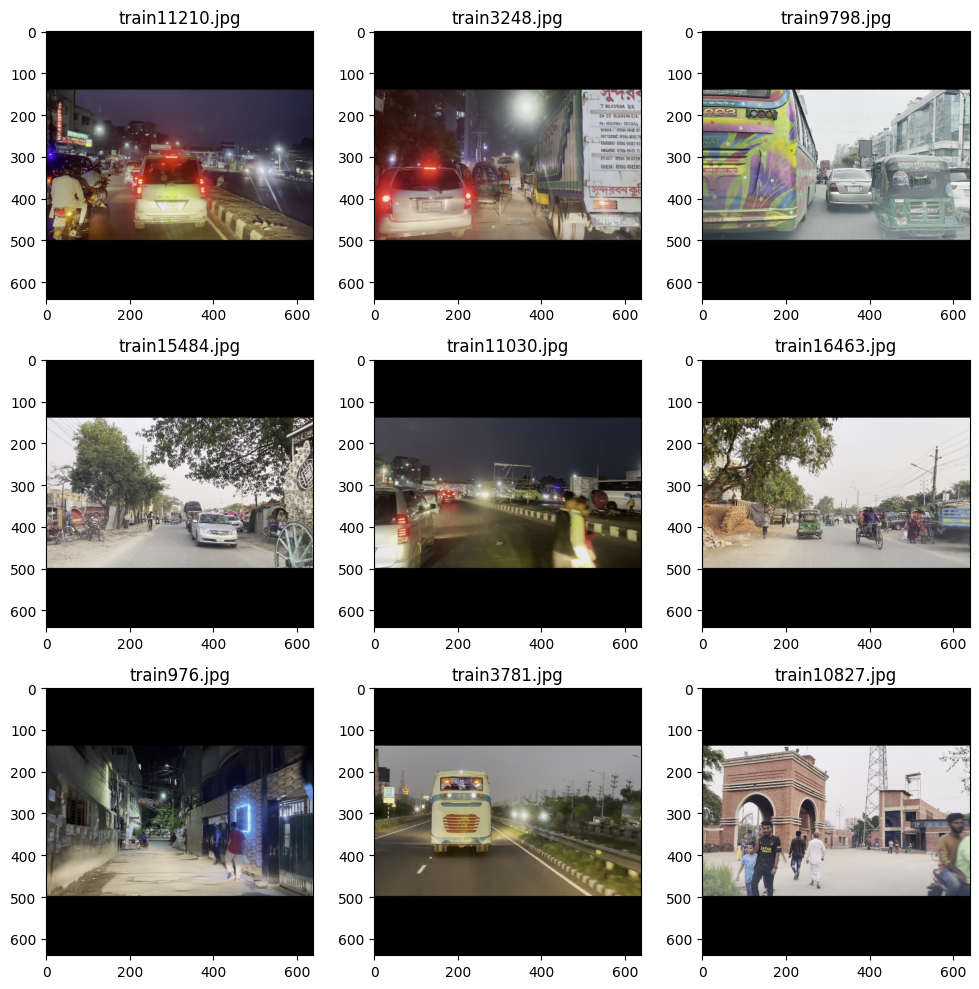

In [61]:
show_img_matrix(img_fc_list[0:9], show_axis=True)

## Utilización de Modelos Pre-entrenados

Esta es la información de casos asociados a la problemática:
- person
- rickshaw
- rickshaw van
- auto rickshaw
- truck
- pickup truck
- private car
- motorcycle
- bicycle
- bus
- micro bus
- covered van
- human hauler

In [62]:
class_names = ["person", "rickshaw", "rickshaw van", "auto rickshaw", "truck",
               "pickup truck", "private car", "motorcycle", "bicycle", "bus",
               "micro bus", "covered van", "human hauler"
]

In [65]:
NEW_ROOT_DIR = f"{ROOT_DIR}/{DATASET_NAME}-Cleaned2"
print(DATA_DIR)

/content/rsud20k-bangladesh-road-scene-understanding/rsud20k


In [66]:
subdirs = ['train', 'test', 'val']
new_train_folder = osp.join(NEW_ROOT_DIR, "images", subdirs[0])
new_val_folder = osp.join(NEW_ROOT_DIR, "images", subdirs[2])
new_test_folder = osp.join(NEW_ROOT_DIR, "images", subdirs[1])

img_tvt_folders = [train_img_folder, val_img_folder, test_img_folder]
new_img_tvt_folders = [new_train_folder, new_val_folder, new_test_folder]

In [67]:
for folder_path in new_img_tvt_folders:
  if not os.path.exists(folder_path):
    os.makedirs(folder_path)

In [68]:
for folder_path in new_img_tvt_folders:
  folder_path = folder_path.replace("/images", "/labels")
  if not os.path.exists(folder_path):
    os.makedirs(folder_path)

Copiamos la información en la estructura que yolo espera:

In [69]:
for i in range(len(img_tvt_folders)):
  old_img_folder = img_tvt_folders[i]
  old_lbl_folder = img_tvt_folders[i].replace("/images", "/labels")
  new_lbl_folder = new_img_tvt_folders[i].replace("/images", "/labels")
  #Obtenemos el listado de archivos de la carpeta
  images = os.listdir(old_img_folder)
  #Los nombres del archivo de imagen y las etiquetas se diferencian por la extensión del archivo
  for img in images:
    #Información del origen de la imagen
    old_img_path = osp.join(old_img_folder, img)
    name, ext = os.path.splitext(old_img_path) #Extraemos la información del nombre y tipo del archivo
    old_lbl_path = osp.join(old_lbl_folder, img.replace(ext, TEXT_EXT))

    new_img_path = osp.join(new_img_tvt_folders[i], img)
    new_lbl_path = osp.join(new_lbl_folder, img.replace(ext, TEXT_EXT))

    if osp.exists(new_img_path) == True:
      os.remove(new_img_path)

    if osp.exists(new_lbl_path) == True:
      os.remove(new_lbl_path)

    #Copia la imagen
    shutil.copy(old_img_path, new_img_path)
    #Copia la etiqueta
    shutil.copy(old_lbl_path, new_lbl_path)

Yolo espera un archivo en formato YAML, que brinde la información sobre la información que acabamos de organizar, clases y otros.

In [70]:
YOLO_DIR = f'/content/{YOLO_VERSION}'

In [71]:
yaml_content = f"""\
path: {NEW_ROOT_DIR}   # dataset root dir
train: images/{osp.basename(new_img_tvt_folders[0])}  # train images (relative to 'path')
val: images/{osp.basename(new_img_tvt_folders[1])}  # val images (relative to 'path')
test: images/{osp.basename(new_img_tvt_folders[2])} # test images (optional)

# Classes
nc: {len(class_names)}

names: {class_names}
"""

YAML_PATH = f'{NEW_ROOT_DIR}/animal-detection.yaml'

if osp.exists(YAML_PATH):
  os.remove(YAML_PATH)

# Guardar el archivo YAML
with open(YAML_PATH, 'w') as yaml_file:
  yaml_file.write(yaml_content)

## Entrenamiento

Teniendo en cuenta que hemos instalado Yolo con el comando PIP, la instancia el modelo debe ser cargado de la siguiente forma:

In [72]:
model = YOLO('yolov8n.yaml')
model = YOLO('yolov8n.pt')


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

Para entrenar el modelo, le damos la información del archivo YAML, el número de épocas, tamaño de la imagen y el batch. De forma opcional vamos a especificar el valor de la paciencia.

In [76]:
model.train(data=YAML_PATH, epochs=50, imgsz=640, batch=16, patience=10)

New https://pypi.org/project/ultralytics/8.3.5 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.4.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/rsud20k-bangladesh-road-scene-understanding-Cleaned2/animal-detection.yaml, epochs=50, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False,

TypeError: unhashable type: 'numpy.ndarray'

Veamos una muestra de los datos que entrenamos:

In [ ]:
Image.open(f'{ROOT_DIR}/runs/detect/train/val_batch0_pred.jpg')

Veamos la matriz de confusión para el modelo entrenado:

In [ ]:
Image.open(f'{ROOT_DIR}/runs/detect/train/confusion_matrix.png')

## Evaluación de Rendimiento

In [ ]:
results = model.val(data=YAML_PATH, imgsz=IMAGE_SIZE)

mAP50: Esta es la precisión promedio calculada en un umbral de IoU (Intersección sobre Unión). En otras palabras, si la superposición entre la caja del objeto predicho y la caja del objeto real es al menos del 50%, entonces se considera una detección correcta.

mAP50-95: Esta es una métrica oficial de COCO que calcula el mAP para un rango de umbrales IoU desde 0.5 hasta 0.95 con un paso de 0.053. En otras palabras, calcula el mAP en umbrales IoU de 0.5, 0.55, 0.6, …, hasta 0.95 y luego toma el promedio3. Esta métrica es más rigurosa y proporciona una mejor indicación del rendimiento del modelo en diferentes niveles de superposición entre las cajas predichas y las reales3.

¿Qué tan bueno fue el proceso?

Ahora una muestra con los elementos de validación, los objetos detectados:

In [ ]:
Image.open(f'{ROOT_DIR}/runs/detect/val/val_batch0_pred.jpg')

## Búsqueda de hiperparámetros

# Ejemplos de detección de objetos con la red entrenada y su respetiva comparación

In [ ]:
predict_path = f'{ROOT_DIR}/runs/detect/predict'

img_list = [filename for filename in os.listdir(predict_path)]
img_count = len(img_list)
print(f"El número total de imágenes es: {img_count}")

In [ ]:
img_fc_list = [osp.join(predict_path, filename) for filename in img_list]

In [ ]:
random.shuffle(img_fc_list)

Visualizamos las imágenes con los ejes, para continuar comprendiendo el uso de los bounding box.

In [ ]:
show_img_matrix(img_fc_list[0:9], show_axis=True)

# Métrica mAP

## Cómo la interpreta para la red entrenada?

# Número de escenarios (imágenes) que involucran personas en el conjunto de prueba